<a href="https://colab.research.google.com/github/ritvik94/Intraday-Price-Movement-Prediction-using-XGBoost/blob/main/Intraday_Price_Movement_Prediction_using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, auc, roc_curve

import collections
from collections import Counter

In [232]:
data = pd.read_csv("/content/ABB_minute.csv")

In [233]:
data.head()

,date,open,high,low,close,volume
0,2015-02-02 09:15:00,1000.85,1005.50,1000.85,1004.40,7478
1,2015-02-02 09:16:00,1004.40,1008.65,1003.90,1004.00,333
2,2015-02-02 09:17:00,1004.00,1007.25,1001.05,1003.90,542
3,2015-02-02 09:18:00,1003.90,1005.35,1003.90,1005.00,51
4,2015-02-02 09:19:00,1005.00,1008.65,1003.40,1005.05,260


In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970889 entries, 0 to 970888
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    970889 non-null  object 
 1   open    970889 non-null  float64
 2   high    970889 non-null  float64
 3   low     970889 non-null  float64
 4   close   970889 non-null  float64
 5   volume  970889 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 44.4+ MB


In [235]:
data.isna().sum().sum()

np.int64(0)

In [236]:
data.duplicated().sum()

np.int64(0)

In [237]:
newdata = data.drop(data.select_dtypes(include=['object']).columns, axis=1)

In [238]:
newdata.head()

,open,high,low,close,volume
0,1000.85,1005.50,1000.85,1004.40,7478
1,1004.40,1008.65,1003.90,1004.00,333
2,1004.00,1007.25,1001.05,1003.90,542
3,1003.90,1005.35,1003.90,1005.00,51
4,1005.00,1008.65,1003.40,1005.05,260


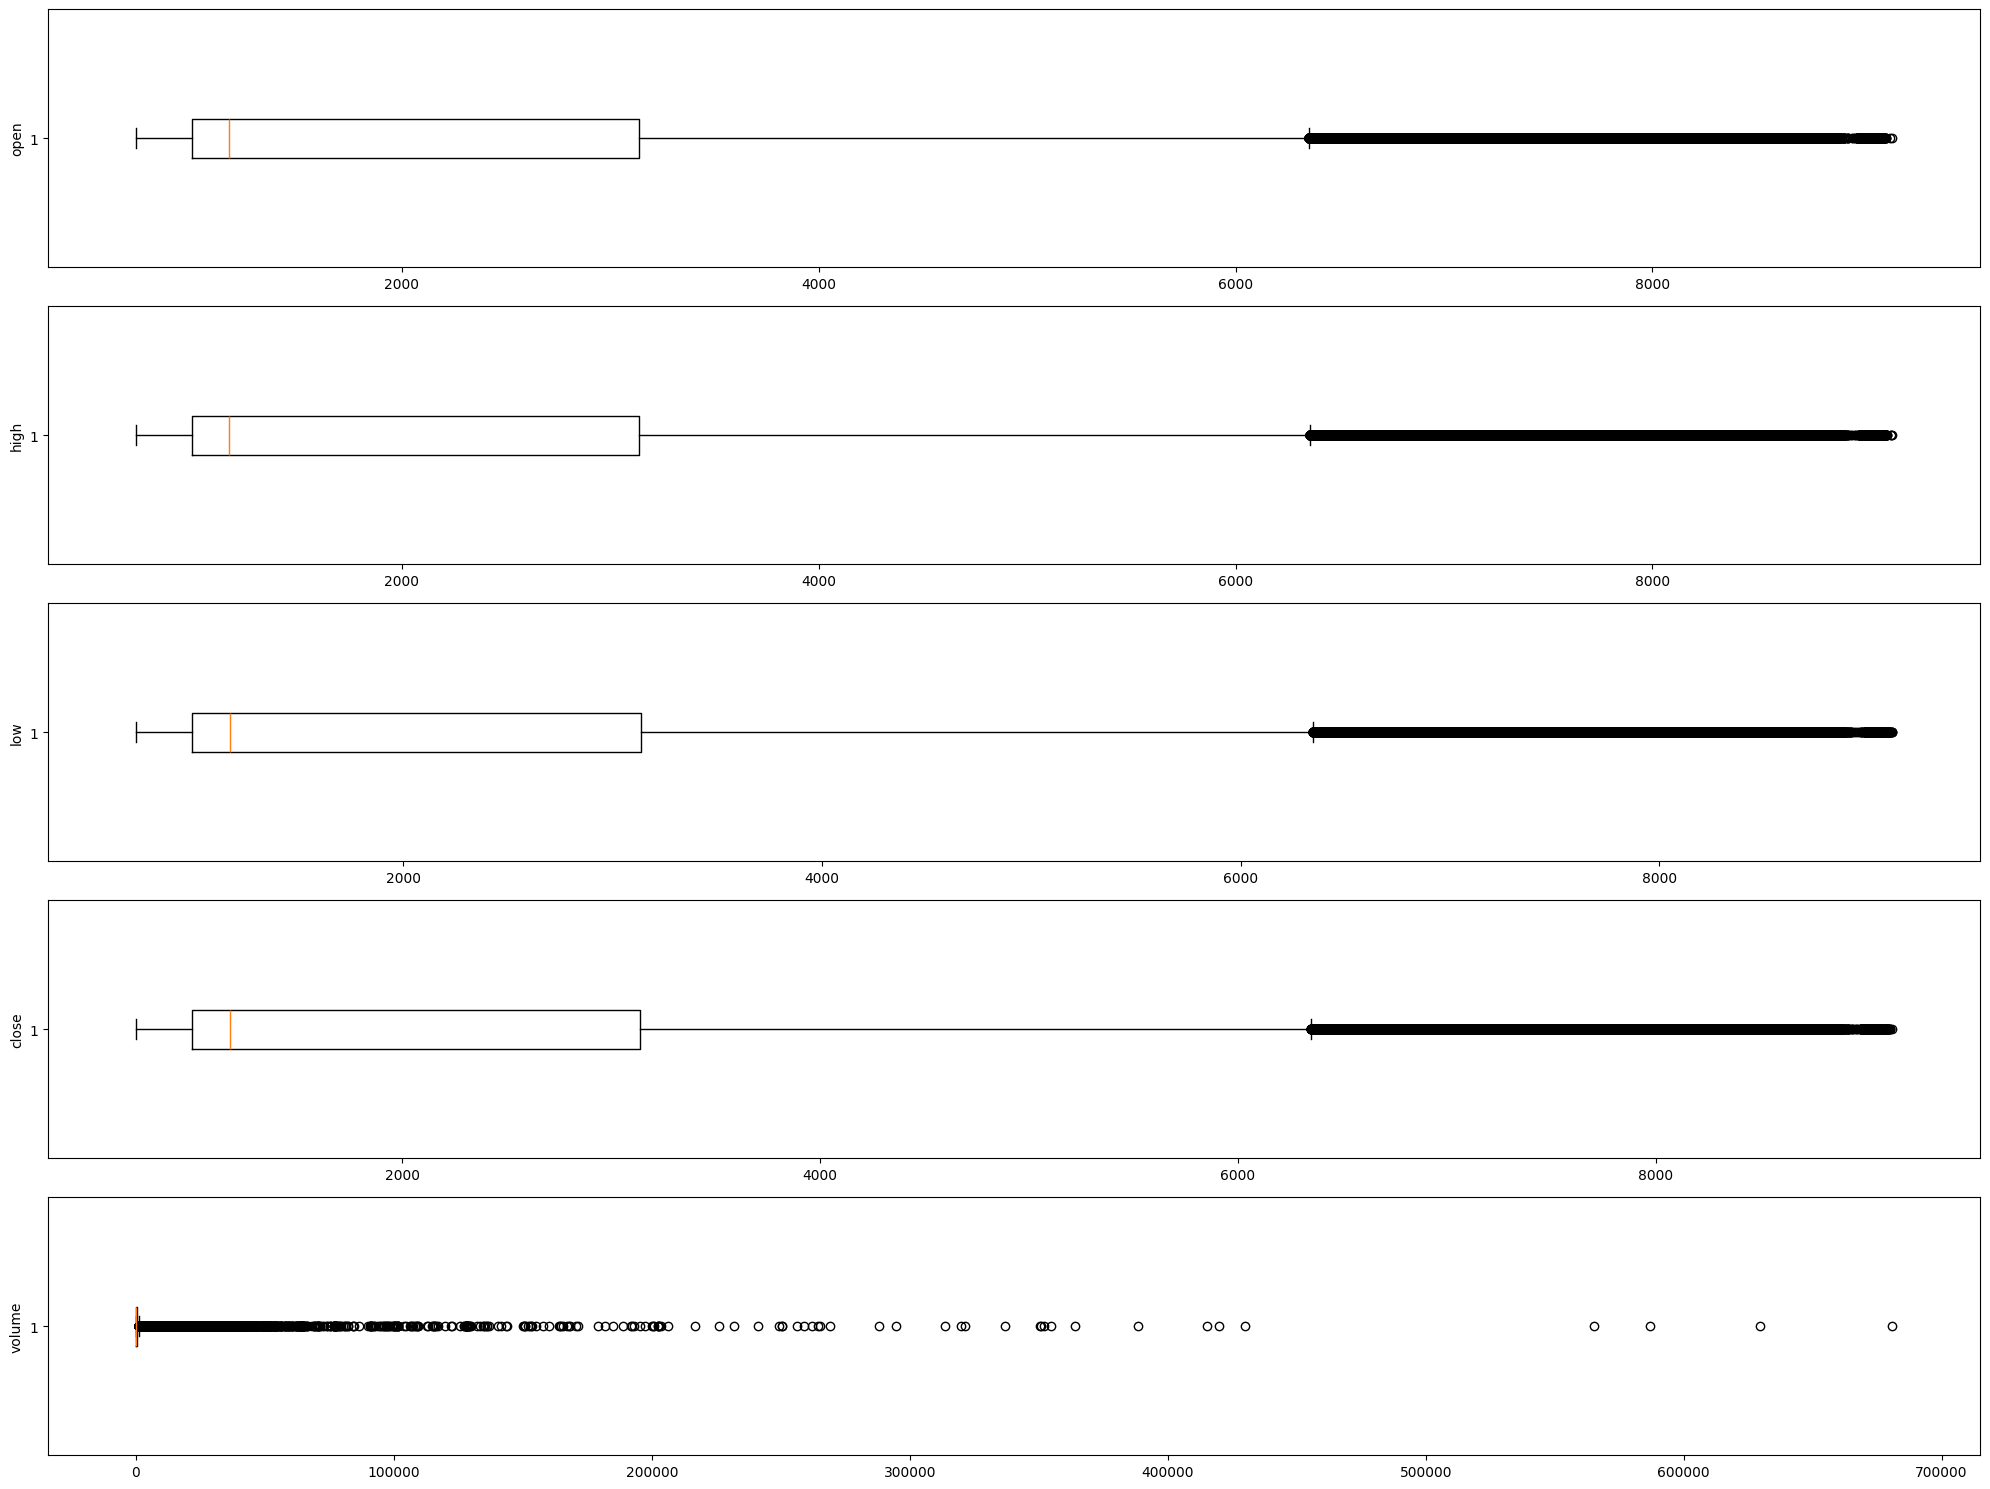

In [239]:
fig, axs = plt.subplots(len(newdata.columns), 1, figsize = (20,15), dpi = 100)
for i, col in enumerate(newdata.columns):
  axs[i].boxplot(newdata[col], vert = False)
  axs[i].set_ylabel(col)
plt.tight_layout()
plt.show()

In [240]:
q1, q3 = np.percentile(newdata['open'], [25, 75])
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
newdata = newdata[(newdata['open'] >= lower) & (newdata['open'] <= upper)]

In [241]:
q1, q3 = np.percentile(newdata['high'], [25, 75])
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
newdata = newdata[(newdata['high'] >= lower) & (newdata['high'] <= upper)]

In [242]:
q1, q3 = np.percentile(newdata['low'], [25, 75])
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
newdata = newdata[(newdata['low'] >= lower) & (newdata['low'] <= upper)]

In [243]:
q1, q3 = np.percentile(newdata['close'], [25, 75])
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
newdata = newdata[(newdata['close'] >= lower) & (newdata['close'] <= upper)]

In [244]:
q1, q3 = np.percentile(newdata['volume'], [25, 75])
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
newdata = newdata[(newdata['volume'] >= lower) & (newdata['volume'] <= upper)]

close     1.000000
low       0.999988
high      0.999987
open      0.999980
volume    0.086729
Name: close, dtype: float64


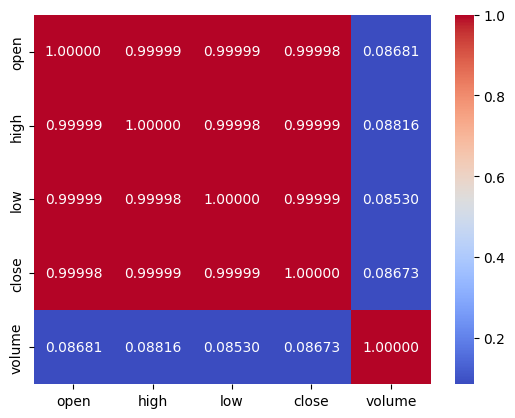

In [245]:
corr = newdata.corr()
plt.figure(dpi=100)
sns.heatmap(corr, annot = True, fmt = '.5f', cmap = 'coolwarm')
print(corr['close'].sort_values(ascending=False))

1 for upward movement and 0 for downward movement

In [246]:
newdata['next_close'] = newdata['close'].shift(-1)
newdata['price_move'] = np.where(newdata['next_close'] > newdata['close'], 1, 0)

In [247]:
features = newdata.drop(['next_close', 'price_move'], axis=1)
target = newdata['price_move']

In [248]:
scaler = StandardScaler()
x = scaler.fit_transform(features)
y = target

In [249]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(xtrain, ytrain)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:46:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [250]:
ypred = xgb_model.predict(xtest)
yproba = xgb_model.predict_proba(xtest)[:,1]

Short-term intraday predictions are stuck near 60–65% accuracy, ROC-AUC ~0.55–0.60 because markets are efficient, data is noisy, features are weak, and most price changes are random micro-fluctuations rather than predictable patterns.




In [251]:
print("Accuracy:", accuracy_score(ytest, ypred))
print("ROC-AUC:", roc_auc_score(ytest, yproba))
print("\nClassification Report:\n", classification_report(ytest, ypred))

Accuracy: 0.6566934991606898
ROC-AUC: 0.5927158471679287

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.98      0.79     68747
           1       0.52      0.03      0.06     36101

    accuracy                           0.66    104848
   macro avg       0.59      0.51      0.43    104848
weighted avg       0.61      0.66      0.54    104848



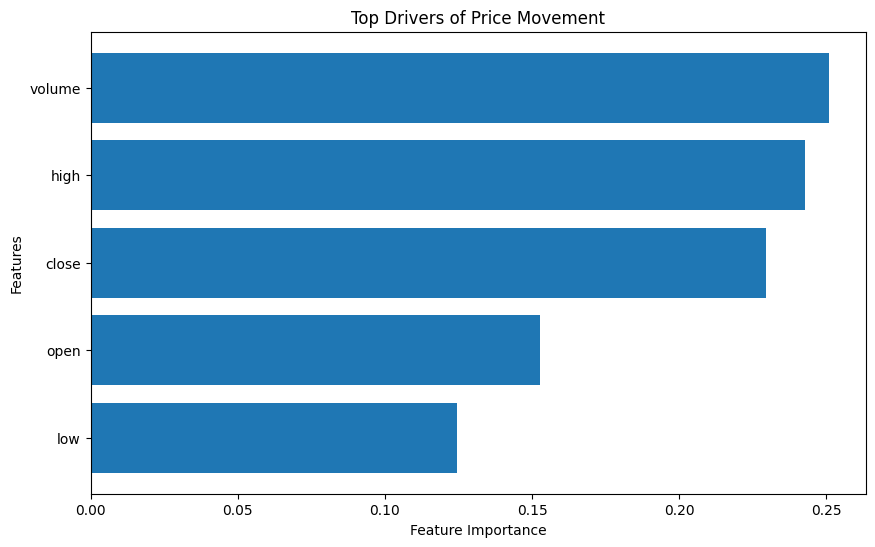

In [252]:
import matplotlib.pyplot as plt
import numpy as np

importances = xgb_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh([features.columns[i] for i in sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top Drivers of Price Movement")
plt.gca().invert_yaxis()
plt.show()